# Exploratory data analysis on message history

# Preliminary notes

The area of study is one text message coming from or going to my phone, and it requires intent either of me or of one my contacts to send a text message (be it an iMessage or a SMS text)

# Setup

In [143]:
# Setup used to include some activation of a venv and installation of packages via !pip, though these were removed in favor of a venv in which the imports below are properly installed. 
# TODO create a requirements.txt so that this notebook is more portable

## Installs

## Imports

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

## Options

In [145]:
pd.options.display.max_rows=300

# Open file and look at general characteristics

In [146]:
sms_orig = pd.read_csv('../../../data/allmessages.csv',  date_format='ISO8601')

/var/folders/2q/8lbypypn4xb0wb2w4nmv421c0000gn/T/ipykernel_20572/1311148020.py:1: DtypeWarning: Columns (4,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sms_orig = pd.read_csv('../../../data/allmessages.csv',  date_format='ISO8601')


In [147]:
sms_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177515 entries, 0 to 177514
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Chat Session     177515 non-null  object
 1   Message Date     177515 non-null  object
 2   Delivered Date   65457 non-null   object
 3   Read Date        101140 non-null  object
 4   Edited Date      50 non-null      object
 5   Service          177515 non-null  object
 6   Type             177515 non-null  object
 7   Sender ID        97926 non-null   object
 8   Sender Name      87976 non-null   object
 9   Status           177246 non-null  object
 10  Replying to      480 non-null     object
 11  Subject          19 non-null      object
 12  Text             166195 non-null  object
 13  Attachment       11315 non-null   object
 14  Attachment type  11318 non-null   object
dtypes: object(15)
memory usage: 20.3+ MB


## What to do with Attachments

In [148]:
sms_orig['Attachment type'].value_counts()

Attachment type
Image         10476
Video           400
Attachment      311
Audio           131
Name: count, dtype: int64

In [149]:
sms_orig[sms_orig['Attachment type']=='Video'].head()

,Chat Session,Message Date,Delivered Date,Read Date,Edited Date,Service,Type,Sender ID,Sender Name,Status,Replying to,Subject,Text,Attachment,Attachment type
236,Sara Stilleke,2020-11-12 18:44:45,2020-11-12 18:44:47,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3761.MOV,Video
391,Sara Stilleke,2020-11-18 14:06:56,2020-11-18 14:07:02,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3841.MOV,Video
411,Sara Stilleke,2020-11-18 22:12:21,2020-11-18 22:12:24,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3862.MOV,Video
1701,Sara Stilleke,2020-12-17 16:16:30,2020-12-17 16:16:33,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_4103.MOV,Video
1717,Sara Stilleke,2020-12-18 15:53:36,2020-12-18 15:53:40,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_4136.MOV,Video


When we start thinking of creating chat 'sitdowns' where both participants are actively texting, and want to decide a cutoff for that, we will want to include these, however when describing the text attributes of messages, these in the text could be a problem. Further EDA with a dataset containing these will need to be done to determine whether videos are often on the tail end of sessions.

# Subset columns

Here we take only the columns that we need for a textual analysis of texts, so we only need a subset of columns. 
- Chat session because we need to know who the text conversation is with
- Message date for time-series analysis and to see the evolution
- Service to see whether it is an iMessage or a SMS, and thus verify a hypothesis about response times on SMS vs iMessages
- Type to understand whether I sent 'Outgoing' or I received 'Incoming'
- Text to have the raw characters that consistute the communication

In [150]:
sms_orig = sms_orig[['Chat Session', 'Message Date', 'Service', 'Type',  'Text']]

# EDA to filter out least contacted senders

Create config class to store specific configuration options

In [151]:
class Config:
    MESSAGE_COUNT_CUTOFF  = 300
    SESSION_TIMEOUT = 15 # in minutes

## Inspect the frequency of senders in the SMS data

In [152]:
message_count = sms_orig['Chat Session'].value_counts()

<Axes: >

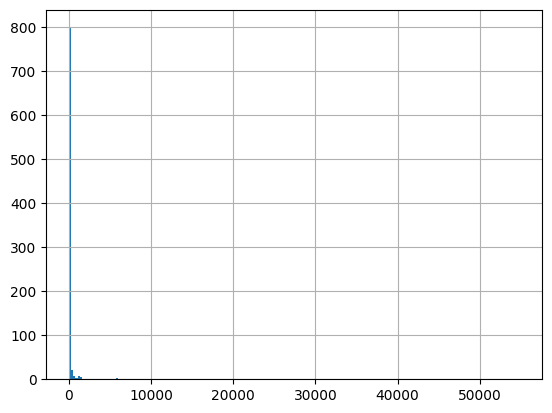

In [153]:
message_count.hist(bins=200)

The distributions of messages per sender is very long-tailed. To give a more useful view, we switch the x axis to log scale.

Text(0, 0.5, 'Frequency')

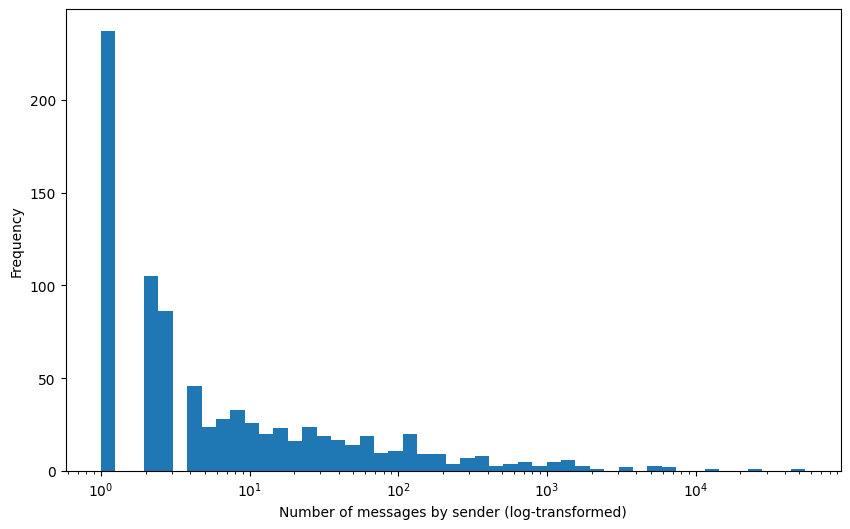

In [154]:
logbins = np.geomspace(message_count.min(), message_count.max(), 50)

plt.figure(figsize=(10, 6))
plt.hist(message_count, bins=logbins)
plt.xscale('log')
plt.xlabel('Number of messages by sender (log-transformed)')
plt.ylabel('Frequency')

In [155]:
'In  an attempt to make the EDA less sensitive to senders I barely interacted with, let\'s cut all senders having sent less than {} messages.'.format(Config.MESSAGE_COUNT_CUTOFF)

"In  an attempt to make the EDA less sensitive to senders I barely interacted with, let's cut all senders having sent less than 300 messages."

In [156]:
all_senders  = message_count.index
selected_senders = message_count[message_count >= Config.MESSAGE_COUNT_CUTOFF].index
sms = sms_orig[sms_orig['Chat Session'].isin(selected_senders)]


In [157]:
'Setting the cutoff at {0} messages yields {1:.1%} percent of messages and {2:.1%} percent of senders'.format(int(Config.MESSAGE_COUNT_CUTOFF), float(sms.shape[0] / sms_orig.shape[0]), float(selected_senders.size / all_senders.size))

'Setting the cutoff at 300 messages yields 90.9% percent of messages and 5.8% percent of senders'

## Inspect the message type

In [158]:
sms['Type'].value_counts()

Type
Incoming        88424
Outgoing        72851
Notification       27
Name: count, dtype: int64

In [159]:
sms[sms['Type']=='Notification'].head(1)

,Chat Session,Message Date,Service,Type,Text
56371,Addison Edwards,2018-04-12 22:43:37,iMessage,Notification,Addison Edwards kept an audio message from you.


Notifications are not in the area of study, thus they will be discarded for the rest of the EDA

In [160]:
sms = sms[sms['Type'] != 'Notification']

## Inspect time series by month of SMS activity

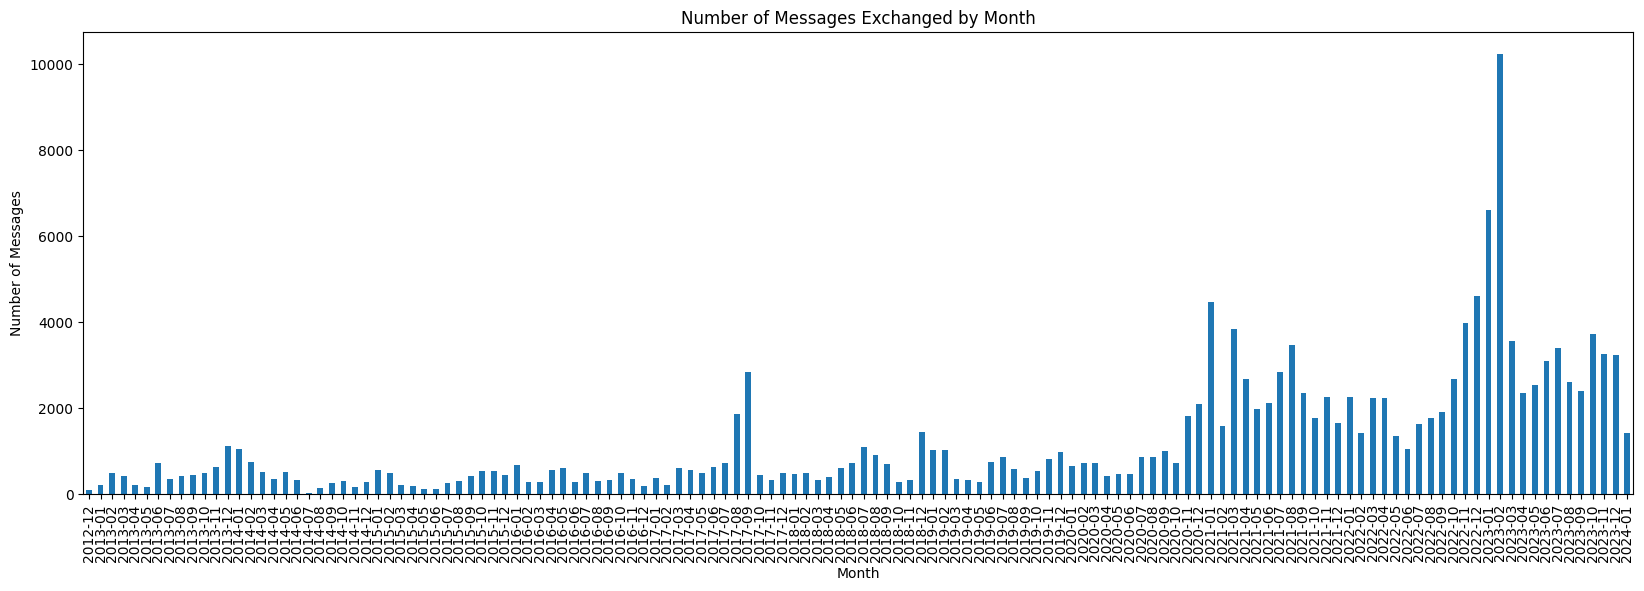

In [161]:
sms['date'] = pd.to_datetime(sms['Message Date'])

# Extract the month from the 'date' column
sms['month'] = sms['date'].dt.to_period('M')

# Group the data by month and count the number of messages for each month
messages_by_month = sms.groupby('month').size()

# Plot the number of messages exchanged by month
plt.figure(figsize=(20, 6))
messages_by_month.plot(kind='bar', xlabel='Month', ylabel='Number of Messages', title='Number of Messages Exchanged by Month')

plt.show()

## Create a few dimensions, measures

In [162]:
sms['Text Length'] = sms['Text'].str.len()
sms['Message Day'] = pd.to_datetime(sms['Message Date']).dt.round('D')
sms['Message Hour'] = pd.to_datetime(sms['Message Date']).dt.to_period('h')
sms['Message Month'] = pd.to_datetime(sms['Message Date']).dt.to_period('M')
sms['Message Yearmo'] =  pd.to_datetime(sms['Message Date']).apply(lambda x: x.strftime('%Y%m'))


sms['Message Has Heart Kiss'] = sms['Text'].map(lambda x : '😘' in str(x))
sms['Message Has Happy Kiss'] = sms['Text'].map(lambda x : '😚' in str(x))

# What month do I tend to text most in?

In [163]:
pd.to_datetime(sms['Message Date']).dt.month_name().value_counts()

Message Date
January      19703
February     17642
December     16552
November     14365
August       13193
March        13006
September    12976
July         12486
October      11870
June         10205
April        10194
May           9083
Name: count, dtype: int64

In [199]:

def groupandplotstacked100(data=sms, by_col=['Type'], agg='sum', extracttopnvalues=300 , **kwargs):
    """
    This function groups its first argument, a dataframe (must contain a column called 'Text Length'), 
    by an array of column names by_col 
    (optionally extracgint the top integer extracttopnvalues values and grouping the rest into other≠≠ ),
      aggregates the text length by either sum or count
    
    It then returns the stacked to 100% barchart 
    """
    date_division = 'Message Yearmo'

    assert('Text Length' in sms.columns)
    assert(date_division in sms.columns)
    assert(by_col in sms.columns)

    sms.loc[sms[by_col].isin((sms[by_col].value_counts()[sms[by_col].value_counts() < extracttopnvalues]).index), by_col] = 'other'

    if agg == 'sum':
        messages_by_month = sms.groupby([date_division, by_col])['Text Length'].sum()
        ylabel_agg = 'Aggregate Message Length'
    elif agg =='count':
        messages_by_month = sms.groupby([date_division, by_col])['Text Length'].count()
        ylabel_agg = 'Number of Messages'
    else:
        KeyError("Err: agg is not within expected parameters.")

    # Plot the number of messages exchanged by month

    plt.figure(figsize=(20, 6))
    messages_by_month_unstacked = messages_by_month.unstack().fillna(0)

    messages_by_month_unstacked = messages_by_month_unstacked.divide(messages_by_month_unstacked.sum(axis=1), axis=0)

    messages_by_month_unstacked.plot(kind='bar', xlabel=date_division, ylabel=ylabel_agg, title=ylabel_agg+' sent by '+ str(by_col)+ ' over Year then Month', stacked=True)

    # plt.hlines(0.5, 0, 1000, color='grey')

    return(plt)

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

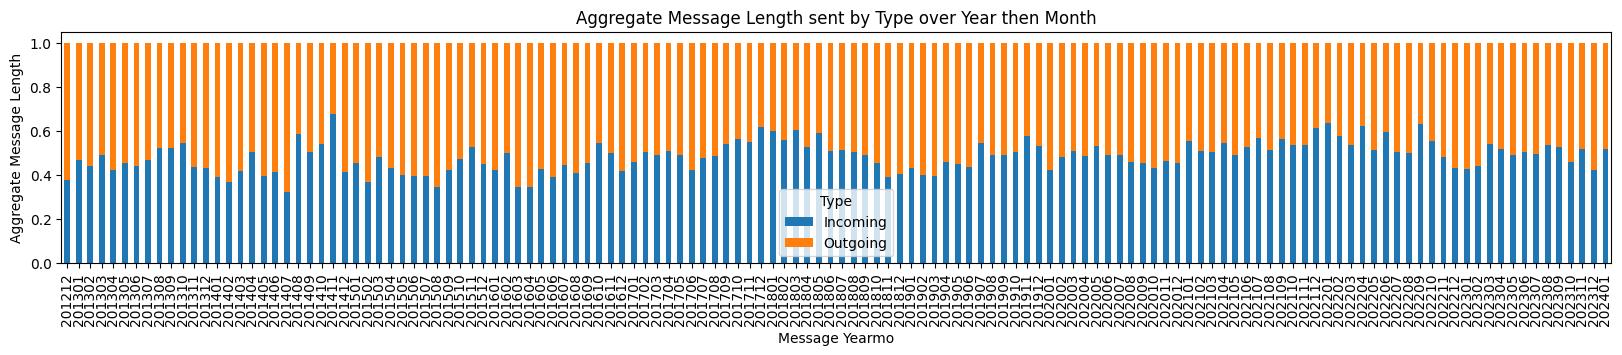

In [200]:
plt.figure(figsize=(20, 6))
groupandplotstacked100(data=sms, by_col='Type').show()

<module 'matplotlib.pyplot' from '/Users/nicolas/Documents/code/notebooks/gitvenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 2000x600 with 0 Axes>

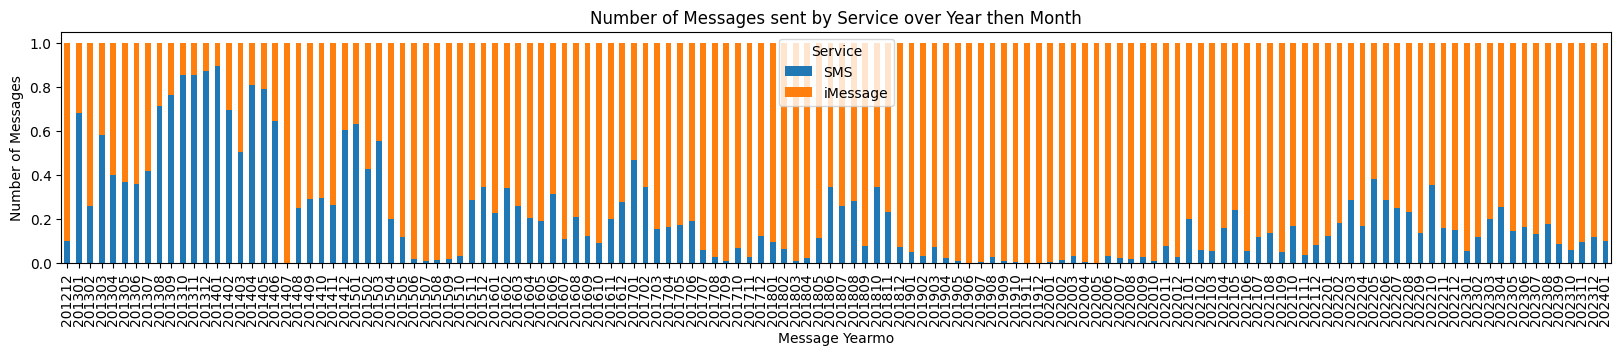

In [201]:
groupandplotstacked100(data=sms, by_col='Service', agg='count')

<module 'matplotlib.pyplot' from '/Users/nicolas/Documents/code/notebooks/gitvenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 2000x600 with 0 Axes>

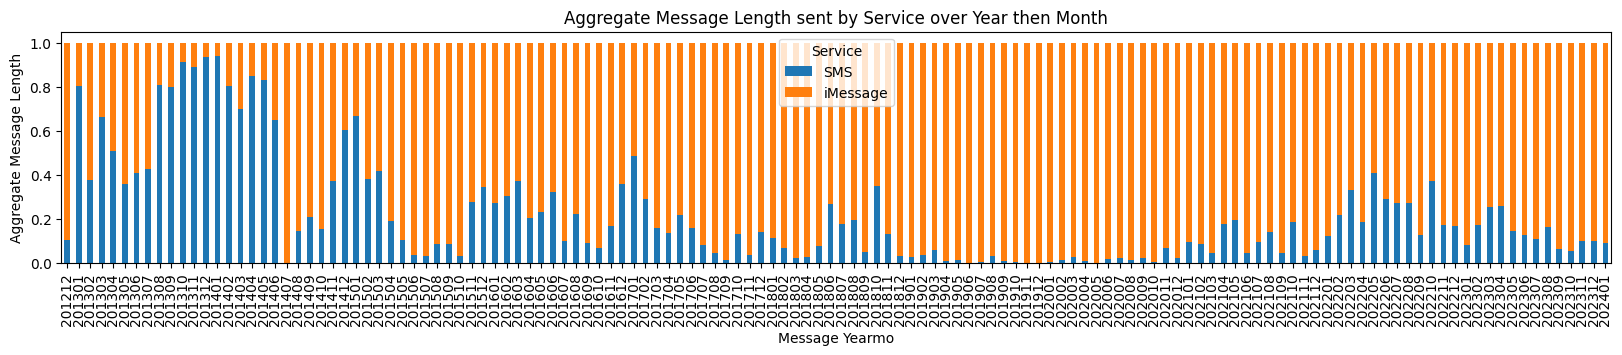

In [202]:
groupandplotstacked100(data=sms, by_col='Service', agg='sum')

<module 'matplotlib.pyplot' from '/Users/nicolas/Documents/code/notebooks/gitvenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 2000x600 with 0 Axes>

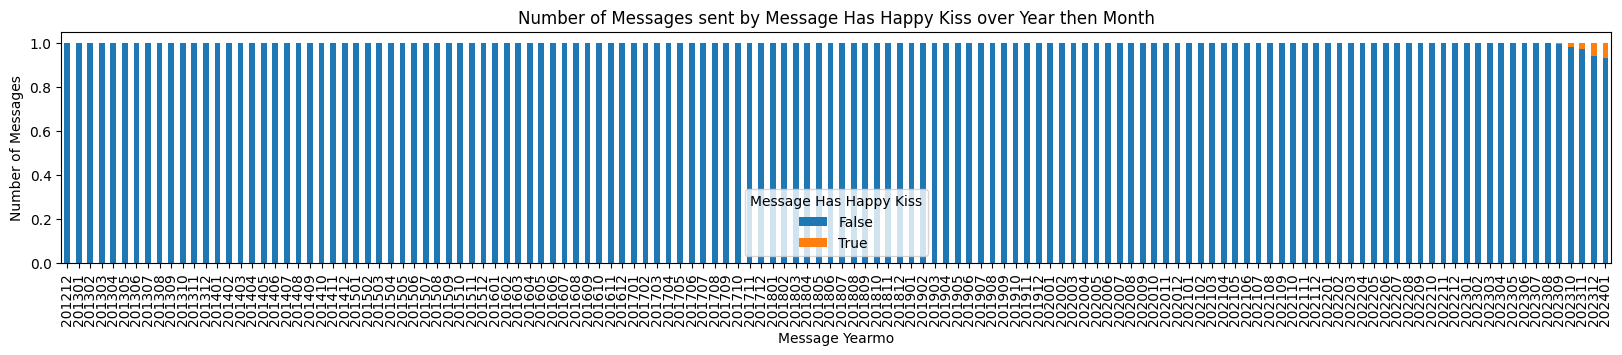

In [203]:
groupandplotstacked100(data=sms[sms['Chat Session']=='Sara Stilleke'], by_col='Message Has Happy Kiss', agg='count')

<module 'matplotlib.pyplot' from '/Users/nicolas/Documents/code/notebooks/gitvenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 2000x600 with 0 Axes>

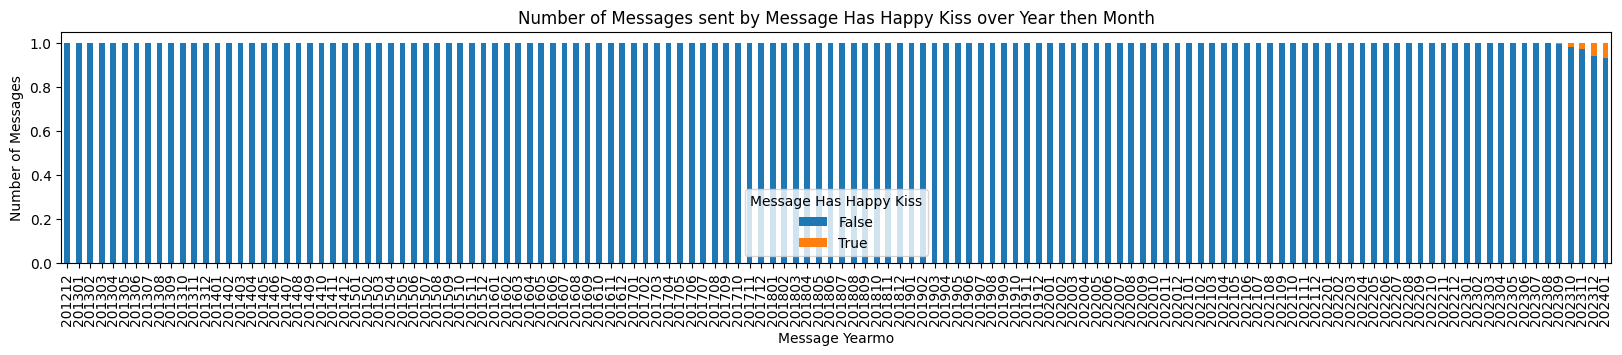

In [204]:
groupandplotstacked100(data=sms[sms['Chat Session']=='Sara Stilleke'], by_col='Message Has Happy Kiss', agg='count')

<module 'matplotlib.pyplot' from '/Users/nicolas/Documents/code/notebooks/gitvenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 2000x600 with 0 Axes>

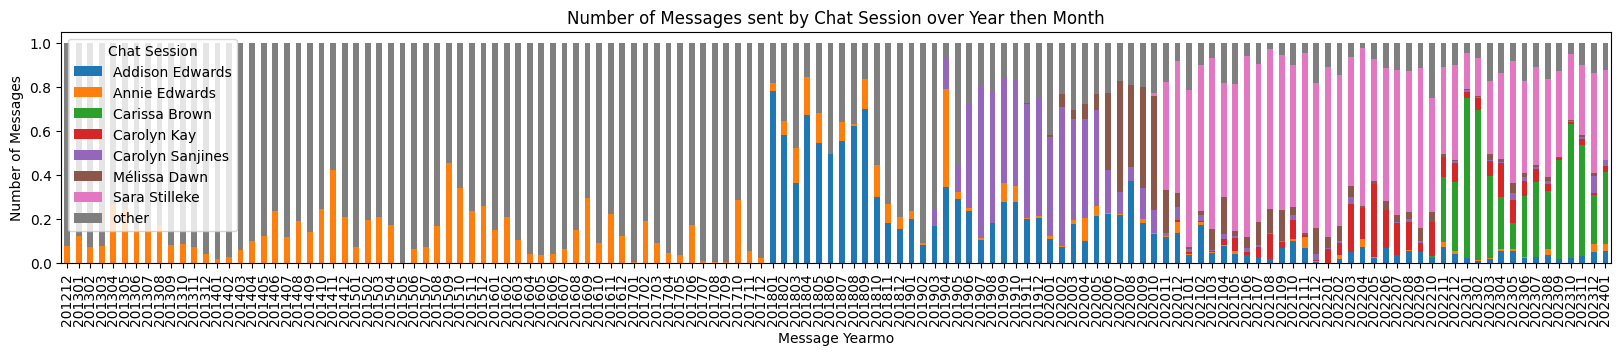

In [208]:
groupandplotstacked100(data=sms, by_col='Chat Session', agg='count', extracttopnvalues=5000)

# Feature enginnering at the message level

In [171]:
sms.groupby(['Chat Session'])['Message Has Heart Kiss'].sum().sort_values(ascending=False).head(10)

Chat Session
Sara Stilleke                               1475
Jennifer Roth                                 51
Carolyn Sanjines                              45
Mélissa Dawn                                  13
+14153149059                                   6
Mélissa Dawn & Jarred Hand & Carolyn Kay       2
Carolyn Kay                                    2
Carissa Brown                                  1
Ali H.                                         1
+18324887538                                   1
Name: Message Has Heart Kiss, dtype: int64

In [172]:
sms['Text'].map(lambda x : '😘' in str(x)).value_counts()

Text
False    159675
True       1600
Name: count, dtype: int64

In [173]:


sms['Text'].map(lambda x : '😘' in str(x)).value_counts()

Text
False    159675
True       1600
Name: count, dtype: int64

Tenderloin Water Athletic Team's various groupchats are aggregated into one session

In [174]:
sms.loc[sms['Chat Session']=='Chris Swim & Darryl Pierce & Jarrod Amsterdam & James Perry & +19405773150 & Chris Farris & +14155677107 & John Vochatzer & David Young', 'Chat Session']='TWATs'
sms['Chat Session'].value_counts().head(25)

Chat Session
Sara Stilleke                  54819
Carissa Brown                  24809
Addison Edwards                11977
Carolyn Kay                     6504
Mélissa Dawn                    5981
Carolyn Sanjines                5873
Annie Edwards                   5226
+14153149059                    4825
TWATs                           4371
Anne-Marie Stoliaroff-Pepin     3668
+33783777709                    1989
Matt Jacobson                   1776
+33762164219                    1584
Antoine St-Pierre               1573
+33663525569                    1518
addiiison@icloud.com            1457
Jennifer Roth                   1413
Nathalie Villa-Vialaneix        1335
Kevin Oswald                    1316
Sugandan Barathy                1204
Victoria Edwards                1180
Mike                            1128
Tanguy Aurore                   1108
Benjamin Harding                1046
Max A. Edwards                   951
Name: count, dtype: int64

<Axes: >

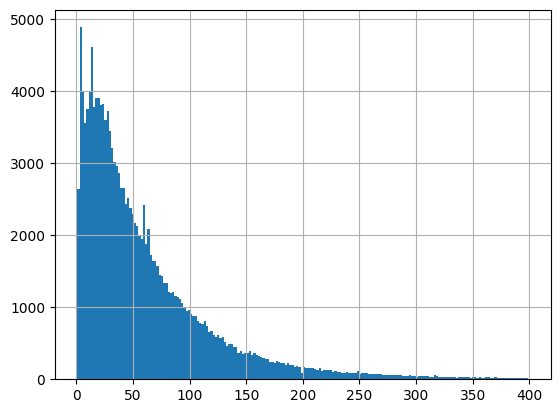

In [176]:
sms[sms['Text Length'] < 400.0]['Text Length'].hist(bins=200)

In [177]:
sms['Service'].value_counts(dropna=False)

Service
iMessage    135053
SMS          26222
Name: count, dtype: int64

TODO plot this over time, also answer the question am I less likely to answer an SMS than an iMessage

In [178]:
sms[sms['Chat Session']=='Sara Stilleke']['Type'].value_counts()

Type
Incoming    27877
Outgoing    26942
Name: count, dtype: int64

TODO look at the breakdown of incoming/outgoing by Chat Session

In [179]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161275 entries, 133 to 176876
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Chat Session            161275 non-null  object        
 1   Message Date            161275 non-null  object        
 2   Service                 161275 non-null  object        
 3   Type                    161275 non-null  object        
 4   Text                    150975 non-null  object        
 5   date                    161275 non-null  datetime64[ns]
 6   month                   161275 non-null  period[M]     
 7   Text Length             150975 non-null  float64       
 8   Message Day             161275 non-null  datetime64[ns]
 9   Message Hour            161275 non-null  period[h]     
 10  Message Month           161275 non-null  period[M]     
 11  Message Yearmo          161275 non-null  object        
 12  Message Has Heart Kiss  161275 no

<Axes: xlabel='Chat Session'>

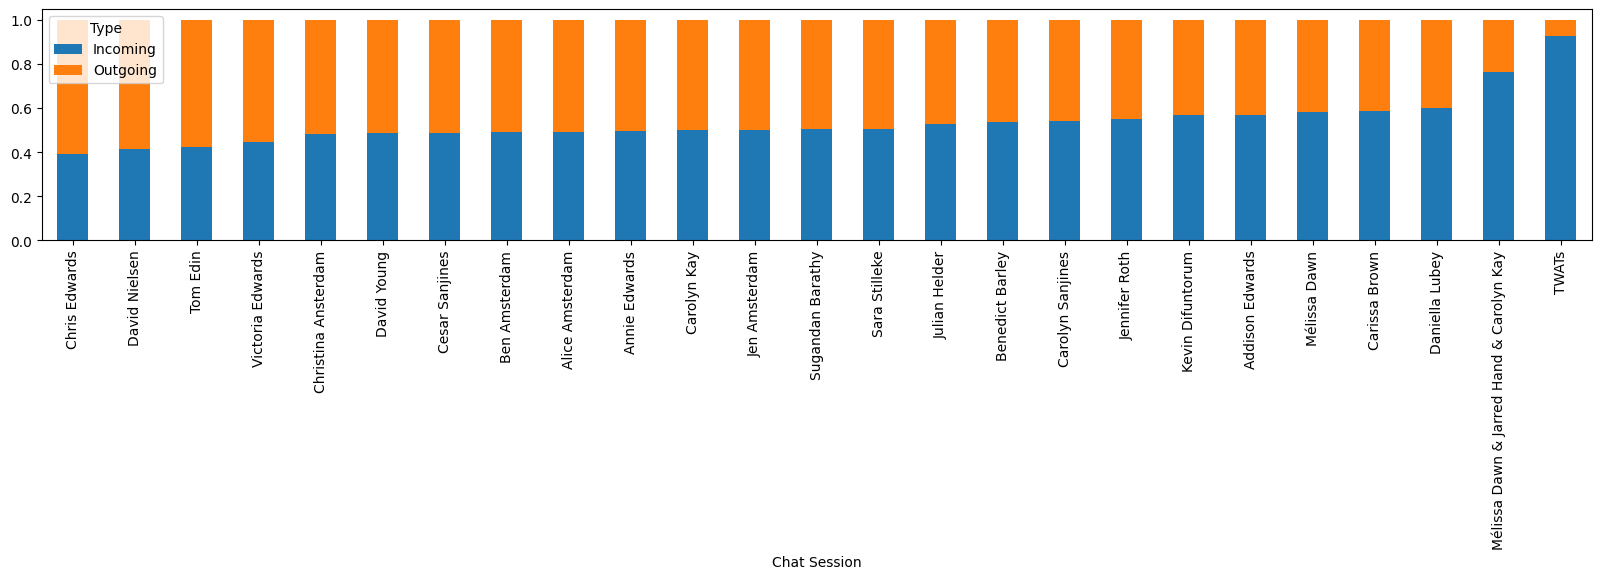

In [180]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)


last_year_contacts = sms[sms['date'].dt.year >= 2023]['Chat Session'].unique()

sms[sms['Chat Session'].isin(last_year_contacts)].groupby(['Chat Session'])['Type']\
.value_counts(normalize=True).unstack('Type').sort_values(by='Incoming').plot.bar(stacked=True)

In [181]:
sms.groupby([    'Chat Session', sms['Message Day'].dt.year ])['Text Length'].sum().sort_values().tail(20)

Chat Session                 Message Day
Nathalie Villa-Vialaneix     2013            105312.0
Addison Edwards              2020            106538.0
Jennifer Roth                2019            113481.0
Carolyn Sanjines             2020            118051.0
TWATs                        2023            140536.0
Carissa Brown                2022            151207.0
Carolyn Kay                  2023            155407.0
Carolyn Sanjines             2019            156827.0
Mélissa Dawn                 2021            163302.0
Anne-Marie Stoliaroff-Pepin  2014            168700.0
Mélissa Dawn                 2020            168942.0
Addison Edwards              2018            170747.0
Anne-Marie Stoliaroff-Pepin  2013            174454.0
Sara Stilleke                2020            194590.0
+14153149059                 2017            207086.0
Carolyn Kay                  2022            264877.0
Sara Stilleke                2022            983179.0
Carissa Brown                2023        

In [182]:
smsday = sms.groupby([
    sms['Message Day'].dt.date,
    'Chat Session']
).agg(
     {'Text Length' : ['count', 'sum']}
     
).reset_index()

In [183]:
pd.options.display.max_rows = 100

sms.groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(100)


,Chat Session,Text Length
14,Benedict Barley,294
24,David Young,305
7,Ali H.,306
45,Tom Edin,309
13,Ben Amsterdam,329
28,Kevin Difuntorum,358
39,Paul Aubel,371
21,Christina Ansterdam,374
42,Sugandan Barathy & Ali Saqlain & Nick Schultz ...,382
22,Daniella Lubey,398


In [210]:
sms.groupby(['Chat Session'])['Text Length'].mean().reset_index().sort_values('Text Length').head(10)


,Chat Session,Text Length
2,Carissa Brown,50.191345
0,Addison Edwards,55.604253
7,other,62.941723
4,Carolyn Sanjines,67.072165
1,Annie Edwards,68.303259
6,Sara Stilleke,73.756033
3,Carolyn Kay,79.178389
5,Mélissa Dawn,81.328181


TODO break this down by sent/received and add count

In [212]:
sms[sms['Chat Session']=='Kevin Oswald'][['Chat Session', 'Text']].reset_index()

,index,Chat Session,Text


In [213]:
sms.groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(10)


,Chat Session,Text Length
1,Annie Edwards,4633
4,Carolyn Sanjines,5529
5,Mélissa Dawn,5628
3,Carolyn Kay,6256
0,Addison Edwards,10158
2,Carissa Brown,23941
7,other,43774
6,Sara Stilleke,51056


In [214]:
sms[sms['Message Day'].dt.year > 2020].groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(10)


,Chat Session,Text Length
1,Annie Edwards,815
4,Carolyn Sanjines,1084
5,Mélissa Dawn,3449
0,Addison Edwards,3687
3,Carolyn Kay,6236
7,other,10670
2,Carissa Brown,23941
6,Sara Stilleke,49085


# Remove all text sent by anyone not in the rough top 30

In [216]:
sms['Chat Session'].value_counts().head(70)

Chat Session
Sara Stilleke       54819
other               46086
Carissa Brown       24809
Addison Edwards     11977
Carolyn Kay          6504
Mélissa Dawn         5981
Carolyn Sanjines     5873
Annie Edwards        5226
Name: count, dtype: int64

# Look at only people I texted in the past year

In [217]:
sms.head()

,Chat Session,Message Date,Service,Type,Text,date,month,Text Length,Message Day,Message Hour,Message Month,Message Yearmo,Message Has Heart Kiss,Message Has Happy Kiss
133,Sara Stilleke,2020-10-31 18:57:20,iMessage,Outgoing,NaN,2020-10-31 18:57:20,2020-10,NaN,2020-11-01,2020-10-31 18:00,2020-10,202010,False,False
134,Sara Stilleke,2020-10-31 18:57:20,iMessage,Outgoing,Nick,2020-10-31 18:57:20,2020-10,4.0,2020-11-01,2020-10-31 18:00,2020-10,202010,False,False
135,Sara Stilleke,2020-10-31 19:00:33,iMessage,Incoming,The moon!,2020-10-31 19:00:33,2020-10,9.0,2020-11-01,2020-10-31 19:00,2020-10,202010,False,False
136,Sara Stilleke,2020-10-31 23:19:01,iMessage,Outgoing,Popo’s still there tho,2020-10-31 23:19:01,2020-10,22.0,2020-11-01,2020-10-31 23:00,2020-10,202010,False,False
137,Sara Stilleke,2020-10-31 23:21:46,iMessage,Incoming,So boring they need to arrest the dude!,2020-10-31 23:21:46,2020-10,39.0,2020-11-01,2020-10-31 23:00,2020-10,202010,False,False


In [218]:
last_year_contacts = sms[sms['date'].dt.year == 2024]['Chat Session'].unique()

In [219]:
last_year_contacts

array(['Sara Stilleke', 'other', 'Addison Edwards', 'Annie Edwards',
       'Carolyn Sanjines', 'Carissa Brown', 'Carolyn Kay', 'Mélissa Dawn'],
      dtype=object)

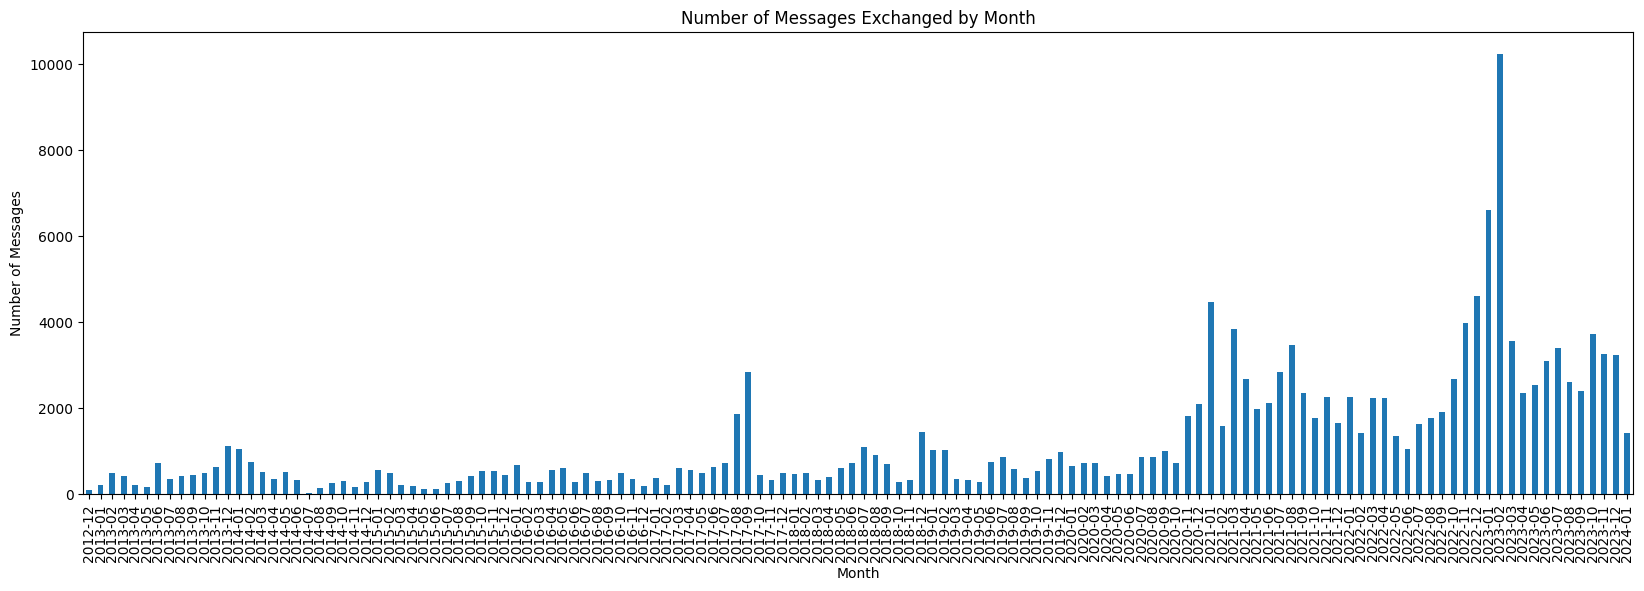

In [220]:
messages_by_month = sms[sms['Chat Session'].isin(last_year_contacts)].groupby('month').size()

# Plot the number of messages exchanged by month
plt.figure(figsize=(20, 6))
messages_by_month.plot(kind='bar', xlabel='Month', ylabel='Number of Messages', title='Number of Messages Exchanged by Month')

plt.show()

# Session creation

ORder SMS by datetime sent, group by sender, lag the datetime, create indicator of datetime greater than 15 minutes

In [221]:
pd.to_datetime(sms['Message Date'])

133      2020-10-31 18:57:20
134      2020-10-31 18:57:20
135      2020-10-31 19:00:33
136      2020-10-31 23:19:01
137      2020-10-31 23:21:46
                 ...        
176872   2014-05-21 01:14:25
176873   2014-05-22 01:02:00
176874   2014-05-22 01:07:46
176875   2014-05-22 01:07:52
176876   2014-05-26 11:28:17
Name: Message Date, Length: 161275, dtype: datetime64[ns]

# Carissa EDA love live

In [222]:
sms['Message Has love'] = sms['Text'].map(lambda x : 'love' in str(x).lower())
sms['Message Has live'] = sms['Text'].map(lambda x : 'live' in str(x).lower())

In [223]:
car = sms[sms['Chat Session']=='Carissa Brown']

In [224]:
cari = car[car['Type']=='Incoming']

In [225]:
cari.shape

(14611, 16)

In [226]:
cari['Message Has love'].value_counts(normalize=True)

Message Has love
False    0.962973
True     0.037027
Name: proportion, dtype: float64

In [227]:
cari['Message Has live'].value_counts(normalize=True)

Message Has live
False    0.995894
True     0.004106
Name: proportion, dtype: float64

# Search for pens to get David for his birthday

In [228]:
pd.options.display.max_colwidth = 160


In [229]:
dave_texts_june = sms[np.logical_and(sms['Chat Session']=='David Young', pd.DatetimeIndex(sms['Message Date']).month==7)]['Text'].reset_index()\
    
dave_texts_june

,index,Text


In [230]:
pd.DatetimeIndex(sms['Message Date']).month

Index([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       ...
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
      dtype='int32', name='Message Date', length=161275)